
# Design an Algorithm for a Dog Identification App 

### by Wenzhe Ding
---

In this notebook, we will be developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, my code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of my finished project. 

Sample Dog Output | Sample Human Output
- | - 
<img src="https://raw.githubusercontent.com/wzding/Machine_Learning_Nanodegree/master/Dog_Identification_App/images/sample_dog_output.png"> | <img src="https://raw.githubusercontent.com/wzding/Machine_Learning_Nanodegree/master/Dog_Identification_App/images/sample_human_output.png">

## Table of contents

* [Import Datasets](#step0)
    * [Import Dog Dataset](#Import Dog Dataset)
    * [Import Human Dataset](#Import Human Dataset)
* [Detect Humans](#step1)
    * [Human Face Detector](#Human Face Detector)
* [Detect Dogs](#step2)
    * [Pre-process the Data](#Pre-process the Data2)
    * [Making Predictions](#Making Predictions2)
    * [Dog Detector](#Dog Detector) 
* [Create a CNN to Classify Dog Breeds (from Scratch)](#step3)
    * [Pre-process the Data](#Pre-process the Data3) 
    * [Model Architecture](#Model Architecture3)
    * [Train the Model](#Train the Model3)
    * [Test the Model](#Test the Model3)
* [Create a CNN to Classify Dog Breeds (using Transfer Learning)](#step4)
    * [Obtain Bottleneck Features](#Obtain Bottleneck Features5)
    * [Model Architecture](#Model Architecture5)
    * [Train the Model](#Train the Model5)
    * [Test the Model](#Test the Model5)
    * [Predict Dog Breed](#Predict Dog Breed)
* [Finalize Our Algorithm](#step5)
* [Test Our Algorithm](#step6)

---
<a id='step0'></a>
## Step 0: Import Datasets
[[ go back to the top ]](#Table-of-contents)

<a id='Import Dog Dataset'></a>
### Import Dog Dataset
[[ go back to the top ]](#Table-of-contents)

We first import a dataset of dog images, and populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


<a id='Import Human Dataset'></a>
### Import Human Dataset
[[ go back to the top ]](#Table-of-contents)

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans
[[ go back to the top ]](#Table-of-contents)

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

Number of faces detected: 1


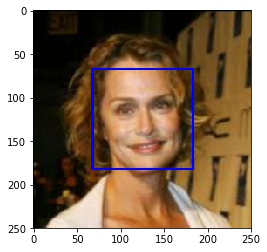

In [3]:
# In this code cell, we demonstrate how to use this detector to find human faces in a sample image.
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

<a id='Human Face Detector'></a>
### Human Face Detector
[[ go back to the top ]](#Table-of-contents)

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

Using this `face_detector` function, there are 98 percent of the first 100 images in `human_files` have a detected human face, while 10 percent of the first 100 images in `dog_files` have a detected human face. Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
human_human = [face_detector(h) for h in human_files_short]
dog_human = [face_detector(d) for d in dog_files_short]
print("total nummber of human faces detected from human dataset", sum(human_human) )
print("total nummber of human faces detected from dog dataset", sum(dog_human) )
## on the images in human_files_short and dog_files_short.

total nummber of human faces detected from human dataset 98
total nummber of human faces detected from dog dataset 11


This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!).We think it is a reasonable expectation to pose on the user because it is better to ask the user to provide a clear image rather than predicting a humam image as a dog.

---
<a id='step2'></a>
## Step 2: Detect Dogs
[[ go back to the top ]](#Table-of-contents)

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [6]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

<a id='Pre-process the Data2'></a>
### Pre-process the Data
[[ go back to the top ]](#Table-of-contents)

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [10]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

<a id='Making Predictions2'></a>
### Making Predictions
[[ go back to the top ]](#Table-of-contents)

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [7]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

<a id='Dog Detector'></a>
### Dog Detector
[[ go back to the top ]](#Table-of-contents)

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [8]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

There are 1 percent of the first 100 images in `human_files` have a detected human face, while 100 percent of the first 100 images in `dog_files` have a detected human face. It means that the dog_detector is more accurate than the human_detector.

In [11]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
human_dog = [dog_detector(h) for h in human_files_short]
dog_dog = [dog_detector(d) for d in dog_files_short]
print("total nummber of dog detected from human dataset", sum(human_dog) )
print("total nummber of dog detected from dog dataset", sum(dog_dog) )

total nummber of dog detected from human dataset 1
total nummber of dog detected from dog dataset 100


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)
[[ go back to the top ]](#Table-of-contents)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, we will create a CNN that classifies dog breeds from scratch. We will not add too many trainable layers!  More parameters means longer training, which means we are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; we can extrapolate this estimate to figure out how long it will take for our algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="https://raw.githubusercontent.com/wzding/Machine_Learning_Nanodegree/master/Dog_Identification_App/images/Brittany_02625.jpg" width="100"> | <img src="https://raw.githubusercontent.com/wzding/Machine_Learning_Nanodegree/master/Dog_Identification_App/images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="https://raw.githubusercontent.com/wzding/Machine_Learning_Nanodegree/master/Dog_Identification_App/images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="https://raw.githubusercontent.com/wzding/Machine_Learning_Nanodegree/master/Dog_Identification_App/images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="https://raw.githubusercontent.com/wzding/Machine_Learning_Nanodegree/master/Dog_Identification_App/images/Labrador_retriever_06457.jpg" width="150"> | <img src="https://raw.githubusercontent.com/wzding/Machine_Learning_Nanodegree/master/Dog_Identification_App/images/Labrador_retriever_06455.jpg" width="240"> | <img src="https://raw.githubusercontent.com/wzding/Machine_Learning_Nanodegree/master/Dog_Identification_App/images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

<a id='Pre-process the Data3'></a>
### Pre-process the Data
[[ go back to the top ]](#Table-of-contents)

We rescale the images by dividing every pixel in every image by 255.

In [16]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:18<00:00, 44.19it/s]


In [17]:
train_tensors.shape

(6680, 224, 224, 3)

<a id='Model Architecture3'></a>
### Model Architecture
[[ go back to the top ]](#Table-of-contents)

Create a CNN to classify dog breed. Here's a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs. It consists of 3 convolutional layers and each follows by a pooling layer. Convolutional layers are locally connected so that they consider the fact that image pixels that are closer in proximity to each other are more closly related than pixels that are far apart. pooling layers reduce the spatial size of the convolutional layers, thus to reduce the amount of parameters and computation in the network, and hence to control overfitting. 

![Sample CNN](https://raw.githubusercontent.com/wzding/Machine_Learning_Nanodegree/master/Dog_Identification_App/images/sample_cnn.png)

In [18]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
__________

<a id='Train the Model3'></a>
### Train the Model
[[ go back to the top ]](#Table-of-contents)

In [19]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

There is another technique to help increase the accuracy of our model - [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not the scope of this project.

In [ ]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 5

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

In [22]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

<a id='Test the Model3'></a>
### Test the Model
[[ go back to the top ]](#Table-of-contents)

The accuracy of our model on the test dataset is very low!

In [23]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 1.9139%


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)
[[ go back to the top ]](#Table-of-contents)

We will now use transfer learning to create a CNN that can identify dog breed from images. In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, we use the bottleneck features from a different pre-trained model.  To make things easier, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-16](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG16Data.npz) bottleneck features
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  

<a id='Obtain Bottleneck Features5'></a>
### Obtain Bottleneck Features
[[ go back to the top ]](#Table-of-contents)
Here we only demonstrate one of the five above networks - ResNet-50 - since it improved our test accuracy from 1.9139% to 79.5455%!

In [36]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']

# bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
# train_VGG16 = bottleneck_features['train']
# valid_VGG16 = bottleneck_features['valid']
# test_VGG16 = bottleneck_features['test']

In [37]:
train_Resnet50.shape

(6680, 1, 1, 2048)

<a id='Model Architecture5'></a>
### Model Architecture
[[ go back to the top ]](#Table-of-contents)

Create a CNN to classify dog breed. Our final CNN architecture includes a pre-trained Resnet-50 model as a fixed feature extractor, where the last convolutional output of Resnet-50 is fed as input to the model. We only added a global average pooling layer and a fully connected layer, where the latter is equipped with a softmax. The architecture is suitable for this problem because the convolutional filters are in hierarchy, most of them are general features that are useful in other dataset.  

In [38]:
### TODO: Define your architecture.
Resnet50_model = Sequential()
Resnet50_model.add(GlobalAveragePooling2D(input_shape= train_Resnet50.shape[1:]))
Resnet50_model.add(Dense(133, activation='softmax'))

Resnet50_model.summary()

# VGG16_model = Sequential()
# VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
# VGG16_model.add(Dense(133, activation='softmax'))

# VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               272517    
Total params: 272,517.0
Trainable params: 272,517.0
Non-trainable params: 0.0
_________________________________________________________________


<a id='Train the Model5'></a>
### Train the Model
[[ go back to the top ]](#Table-of-contents)

In [82]:
#VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
Resnet50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [83]:
# checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
#                                verbose=1, save_best_only=True)
# VGG16_model.fit(train_VGG16, train_targets, 
#           validation_data=(valid_VGG16, valid_targets),
#           epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5', 
                               verbose=1, save_best_only=True)

Resnet50_model.fit(train_Resnet50, train_targets, 
          validation_data=(valid_Resnet50, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=0)

Epoch 00000: val_loss improved from inf to 0.83613, saving model to saved_models/weights.best.Resnet50.hdf5
Epoch 00001: val_loss improved from 0.83613 to 0.65771, saving model to saved_models/weights.best.Resnet50.hdf5
Epoch 00002: val_loss improved from 0.65771 to 0.64002, saving model to saved_models/weights.best.Resnet50.hdf5
Epoch 00003: val_loss did not improve
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss did not improve
Epoch 00006: val_loss did not improve
Epoch 00007: val_loss did not improve
Epoch 00008: val_loss did not improve
Epoch 00009: val_loss did not improve
Epoch 00010: val_loss did not improve
Epoch 00011: val_loss did not improve
Epoch 00012: val_loss did not improve
Epoch 00013: val_loss did not improve
Epoch 00014: val_loss did not improve
Epoch 00015: val_loss did not improve
Epoch 00016: val_loss did not improve
Epoch 00017: val_loss did not improve
Epoch 00018: val_loss did not improve
Epoch 00019: val_loss did not improve


In [39]:
### TODO: Load the model weights with the best validation loss.
Resnet50_model.load_weights('saved_models/weights.best.Resnet50.hdf5')

<a id='Test the Model5'></a>
### Test the Model
[[ go back to the top ]](#Table-of-contents)

Try out your model on the test dataset of dog images.

In [40]:
### TODO: Calculate classification accuracy on the test dataset.
# get index of predicted dog breed for each image in test set
Resnet50_predictions = [np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 79.5455%


<a id='Predict Dog Breed'></a>
### Predict Dog Breed
[[ go back to the top ]](#Table-of-contents)


In this section, we write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by our model.  

Similar to the analogous function in Step 5, our function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

In [41]:
from extract_bottleneck_features import *

def Resnet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Resnet50_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Finalize Our Algorithm
[[ go back to the top ]](#Table-of-contents)

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

In [42]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
def get_dog_breed(img_path):
    if dog_detector(img_path):
        pred = Resnet50_predict_breed(img_path)
        print("This is a %s"%(pred))
        return pred
    if face_detector(img_path):
        pred = Resnet50_predict_breed(img_path)
        print("You look like a %s"%(pred))
        return pred
    else:
        print("Neither dog or human, please check the image again")
        return None

---
<a id='step6'></a>
## Step 6: Test Our Algorithm
[[ go back to the top ]](#Table-of-contents)

In this section, we will take our new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

We'll test our algorithm using six images. The algorithm has better performance of detecting a dog's breed than we expected as it returned 100% accuracy of classifing it. However, its ability to categorize humans into resembling breeds is worse than we expected - there is not even one human face is recogonized among a total of five. But when we set the unrecogonized human face to the Resnet50_model for prediction, it returned 'American_foxhound', indicating that my algorithm could improve the performance of detecting whether an image is a human face or not. 

There are three points that our algorithm could make improvement on:
* improve the performance of face_detector by asking the user to upload a clear image as it is a key factor impacting the accuracy of my algorithm
* improve the performance of face_detector by improve the algorithm itself, such as using pre-trained ResNet-50 model to detect humans in images
* including images that depicting human faces in the training data of Resnet50_model from stop 5 to increase the accuracy of predicting the resembling dog breed of a human face 

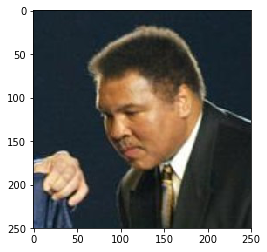

Neither dog or human, please check the image again


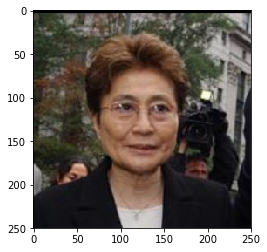

You look like a Cocker_spaniel


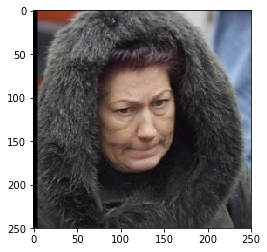

You look like a Field_spaniel


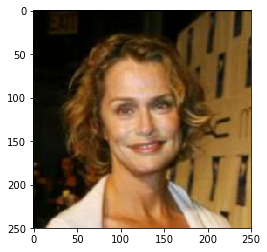

You look like a Basenji


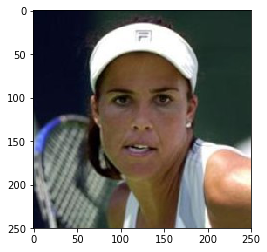

You look like a Basenji


In [46]:
for h in human_files_short[:5]:
    img = cv2.imread(h)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()
    get_dog_breed(h)

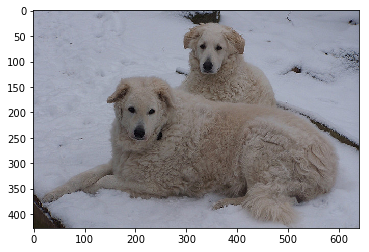

This is a Kuvasz


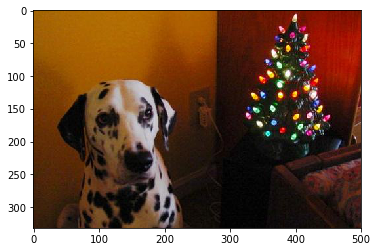

This is a Dalmatian


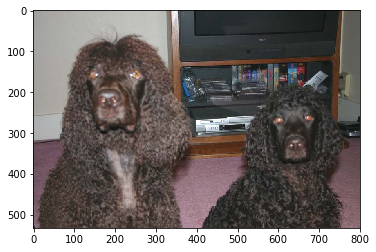

This is a Irish_water_spaniel


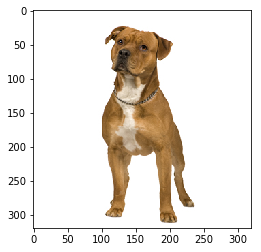

This is a American_staffordshire_terrier


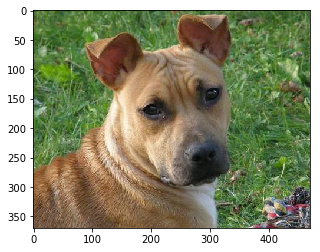

This is a American_staffordshire_terrier


In [48]:
for d in dog_files_short[:5]:
    img = cv2.imread(d)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()
    get_dog_breed(d)